## Bike sharing MLR model

**Problem statement:**

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.


A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 


In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.


They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

Which variables are significant in predicting the demand for shared bikes.
How well those variables describe the bike demands
Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 

**Business Goal:**

You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 


In [1]:
#Import all required library
import pandas as pd, numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

import statsmodels.api as sm
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor


warnings.filterwarnings("ignore")

## Step 1: reading and understanding the data

In [2]:
#read csv dataset in pandas dataframe
bike_df = pd.read_csv("Dataset//day.csv")

In [3]:
#check data shape and column info
print(f'Dataset shape {bike_df.shape}')
bike_df.info()

Dataset shape (730, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


730 is row count and non-null count is also 730 for all, so all the coulmns has complete values. 

In [4]:
#rename columns based on data dictonary for batter understanding
bike_df.rename(columns = {'dteday': 'date','yr':'year','mnth':'month','hum':'humidity','cnt':'count'}, inplace = True) 

In [5]:
#first five dataset view
bike_df.head()

,instant,date,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [6]:
#get unique value count
bike_df.nunique().sort_values() 

year            2
holiday         2
workingday      2
weathersit      3
season          4
weekday         7
month          12
temp          498
humidity      594
casual        605
windspeed     649
registered    678
atemp         689
count         695
date          730
instant       730
dtype: int64

consider unique values count >20 is incremental variable. wherein <20 are Categorical variables.

In [7]:
bike_df['season']=bike_df.season.map({1: 'spring', 2: 'summer',3:'fall', 4:'winter' })
bike_df['month']=bike_df.month.map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
bike_df['weathersit']=bike_df.weathersit.map({1: 'Clear',2:'Mist + Cloudy',3:'Light Snow',4:'Heavy Rain'})
bike_df['weekday']=bike_df.weekday.map({0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'})

In [8]:
bike_df.tail()

,instant,date,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count
725,726,27-12-2019,spring,1,Dec,0,Thu,1,Mist + Cloudy,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,spring,1,Dec,0,Fri,1,Mist + Cloudy,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,spring,1,Dec,0,Sat,0,Mist + Cloudy,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,spring,1,Dec,0,Sun,0,Clear,10.489153,11.58500,48.3333,23.500518,364,1432,1796
729,730,31-12-2019,spring,1,Dec,0,Mon,1,Mist + Cloudy,8.849153,11.17435,57.7500,10.374682,439,2290,2729


## Step 2: Data visualization

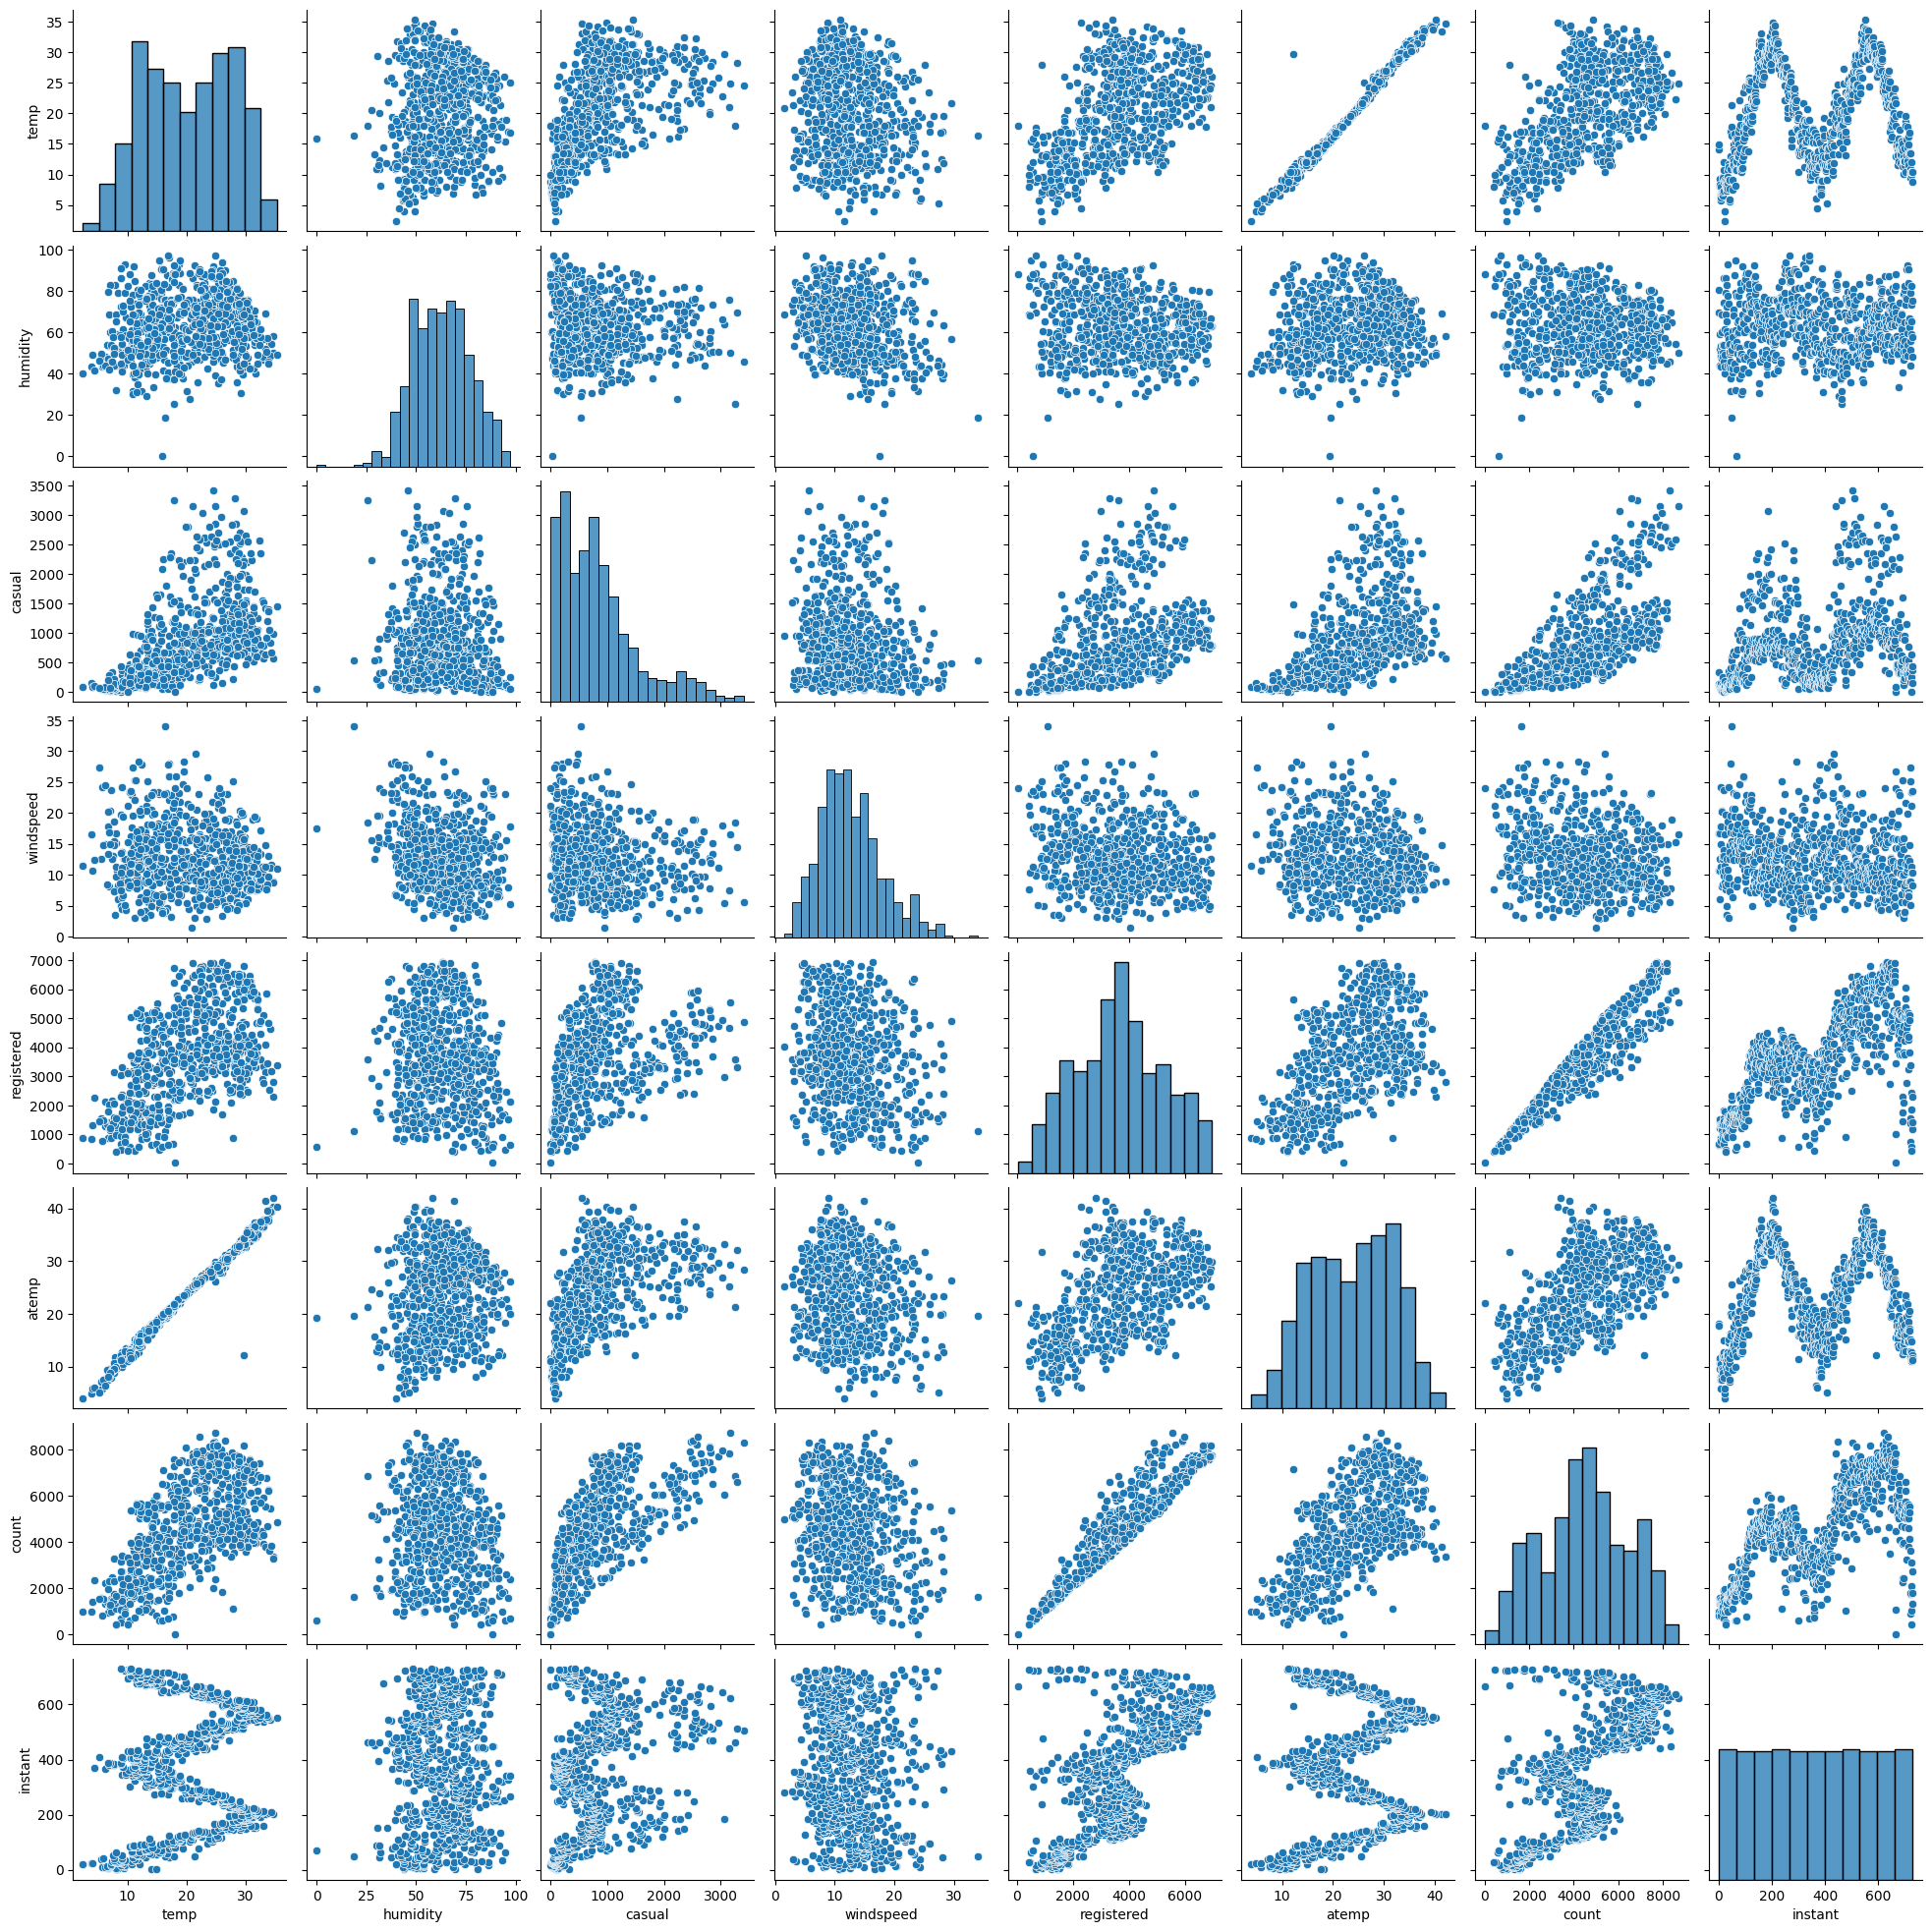

In [9]:
#Pairplot for numeric variables
sns.pairplot(bike_df, vars=["temp", "humidity",'casual','windspeed','registered','atemp','count','instant'])
plt.show()

- Relation with count variable
    - Can see similar distrubtion between temp and atemp, so we can use any one
    - Other variables are correlated to count variable

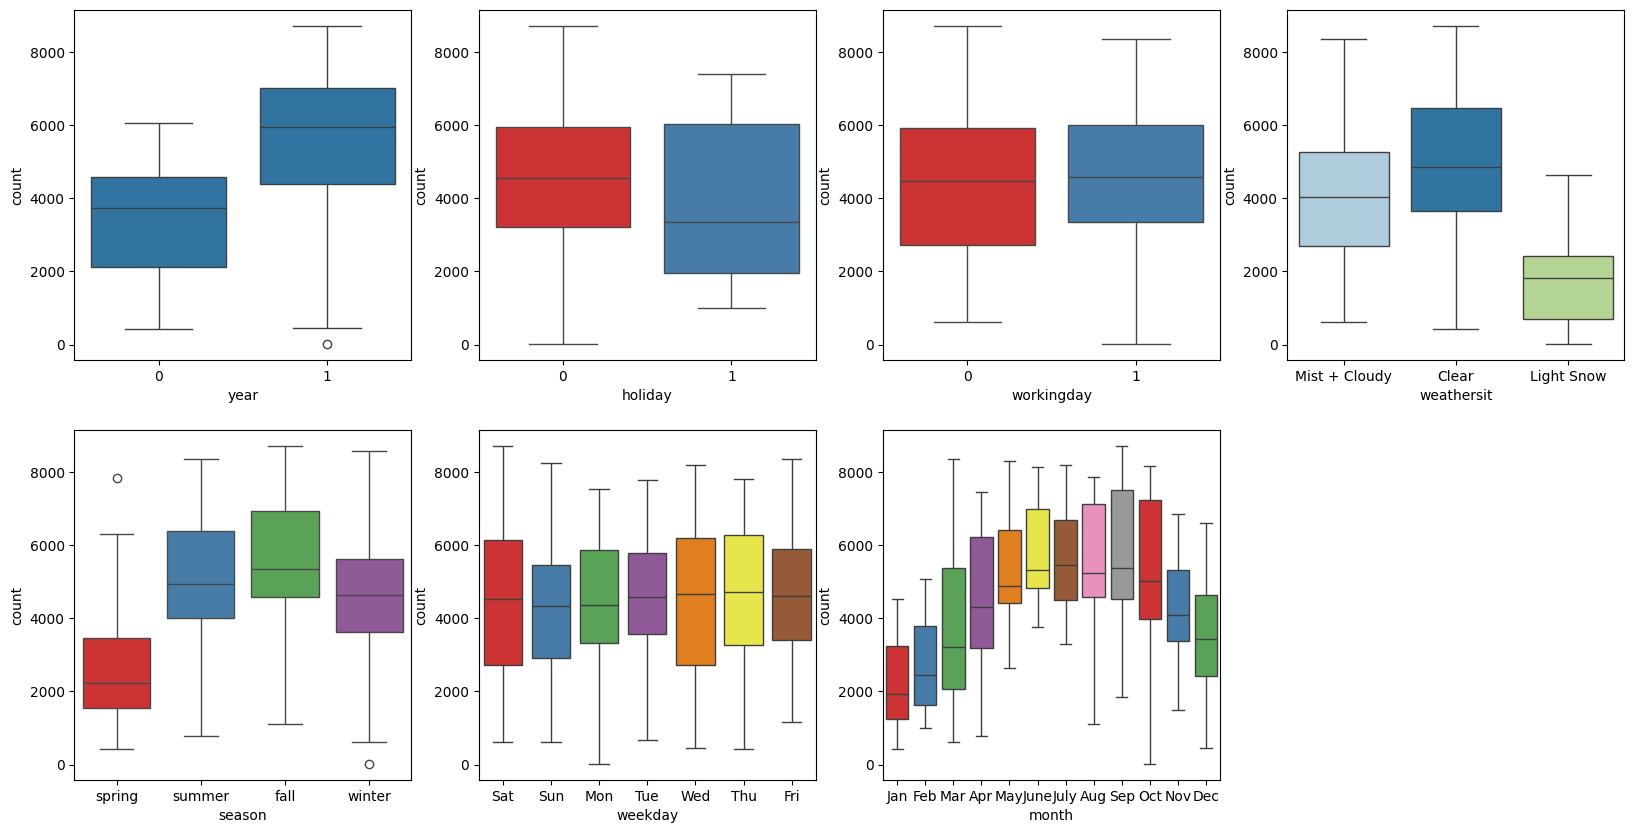

In [10]:
# visualizing the categorical variable
# year            2
# holiday         2
# workingday      2
# weathersit      3
# season          4
# weekday         7
# month          12

plt.figure(figsize=(20,10))

plt.subplot(2,4,1)
sns.boxplot(x="year", y="count", data=bike_df)

plt.subplot(2,4,2)
sns.boxplot(x="holiday",palette="Set1", y="count", data=bike_df)

plt.subplot(2,4,3)
sns.boxplot(x="workingday",palette="Set1", y="count", data=bike_df)

plt.subplot(2,4,4)
sns.boxplot(x="weathersit", palette="Paired", y="count", data=bike_df)

plt.subplot(2,4,5)
sns.boxplot(x="season",palette="Set1", y="count", data=bike_df)

plt.subplot(2,4,6)
sns.boxplot(x="weekday", y="count", palette="Set1", data=bike_df)

plt.subplot(2,4,7)
sns.boxplot(x="month",palette="Set1", y="count", data=bike_df)

plt.show()


From above visualization we can understand that
- 2019 has more booking compared to 2018
- During holiday we can expact bike rental 
- Clear wearther has impact on rental
- High renatal deman during fall and then summer
- Sat, Wed, Thu has high bike rental count
- Mid year months has good number of rentals. 


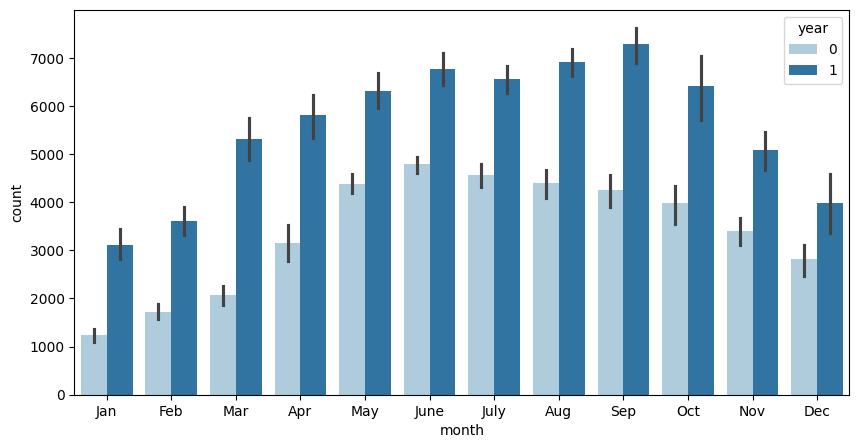

In [11]:
#Relation between month and year
plt.figure(figsize=(10,5))
sns.barplot(x = 'month', y = 'count', hue='year',palette='Paired', data= bike_df)
plt.show()

Can see mid year pattern in both years (2018, 2019)

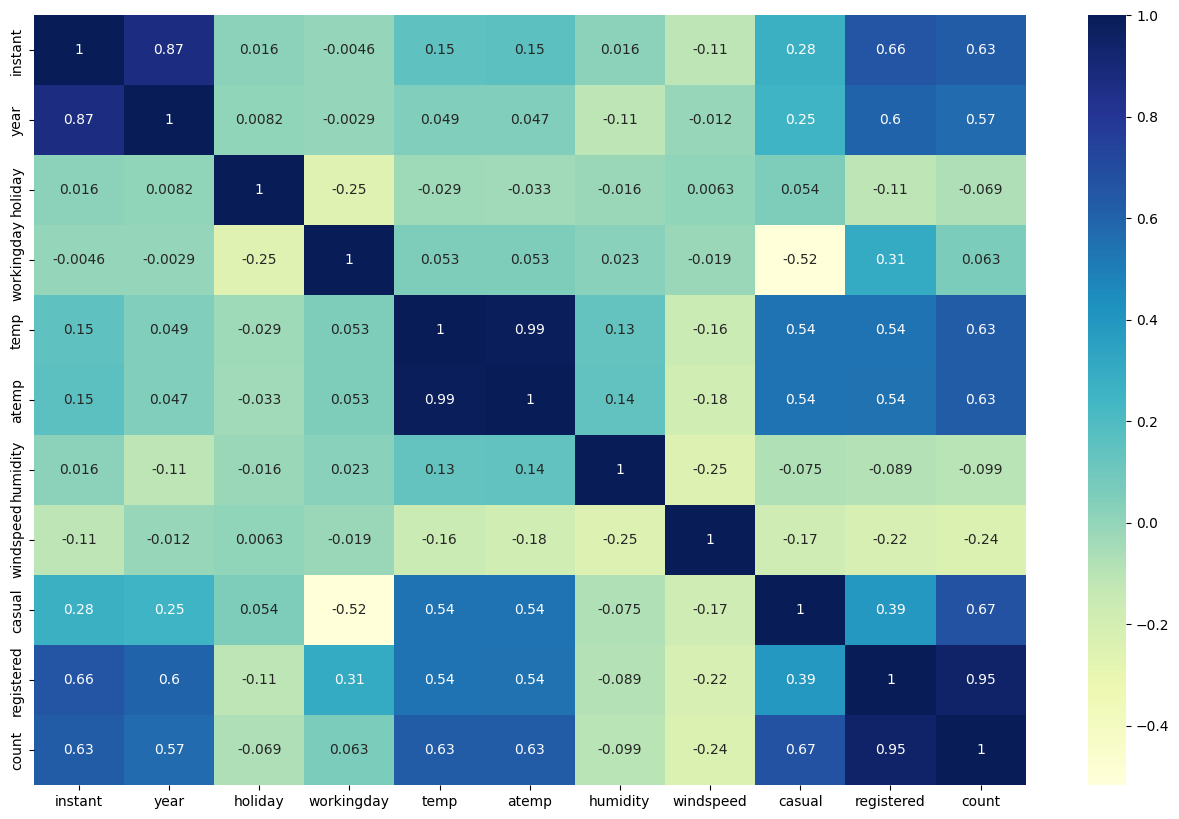

In [12]:
#Heatmap to see correlation between numeric variables
plt.figure(figsize=(16, 10))
sns.heatmap(bike_df.corr(numeric_only=True), cmap='YlGnBu', annot = True)
plt.show()

From heatmap we can say registered, casual, atemp, temp, working and instant variables are correlated with count variable. 

## Step 3: Data Preparation

In [13]:
# drop unnecessary columns
# we can keep any one between temp and atemp but keeping atemp, as based on data it is actual feeling temp. 
bike_df=bike_df.drop(['instant','date','casual', 'registered','temp'], axis=1)
bike_df.head()

,season,year,month,holiday,weekday,workingday,weathersit,atemp,humidity,windspeed,count
0,spring,0,Jan,0,Sat,0,Mist + Cloudy,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Sun,0,Mist + Cloudy,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Mon,1,Clear,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Tue,1,Clear,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Wed,1,Clear,11.46350,43.6957,12.522300,1600


In [14]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   year        730 non-null    int64  
 2   month       730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   atemp       730 non-null    float64
 8   humidity    730 non-null    float64
 9   windspeed   730 non-null    float64
 10  count       730 non-null    int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 62.9+ KB


In [15]:
# Creating dummy variables for categorical variables
bike_df = pd.get_dummies(bike_df,columns=["season","month","weekday","weathersit"],drop_first=True)
print(bike_df.shape)
bike_df.head()

(730, 29)


,year,holiday,workingday,atemp,humidity,windspeed,count,season_spring,season_summer,season_winter,...,month_Oct,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow,weathersit_Mist + Cloudy
0,0,0,0,18.18125,80.5833,10.749882,985,True,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0,0,0,17.68695,69.6087,16.652113,801,True,False,False,...,False,False,False,False,True,False,False,False,False,True
2,0,0,1,9.47025,43.7273,16.636703,1349,True,False,False,...,False,False,True,False,False,False,False,False,False,False
3,0,0,1,10.60610,59.0435,10.739832,1562,True,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0,0,1,11.46350,43.6957,12.522300,1600,True,False,False,...,False,False,False,False,False,False,False,True,False,False


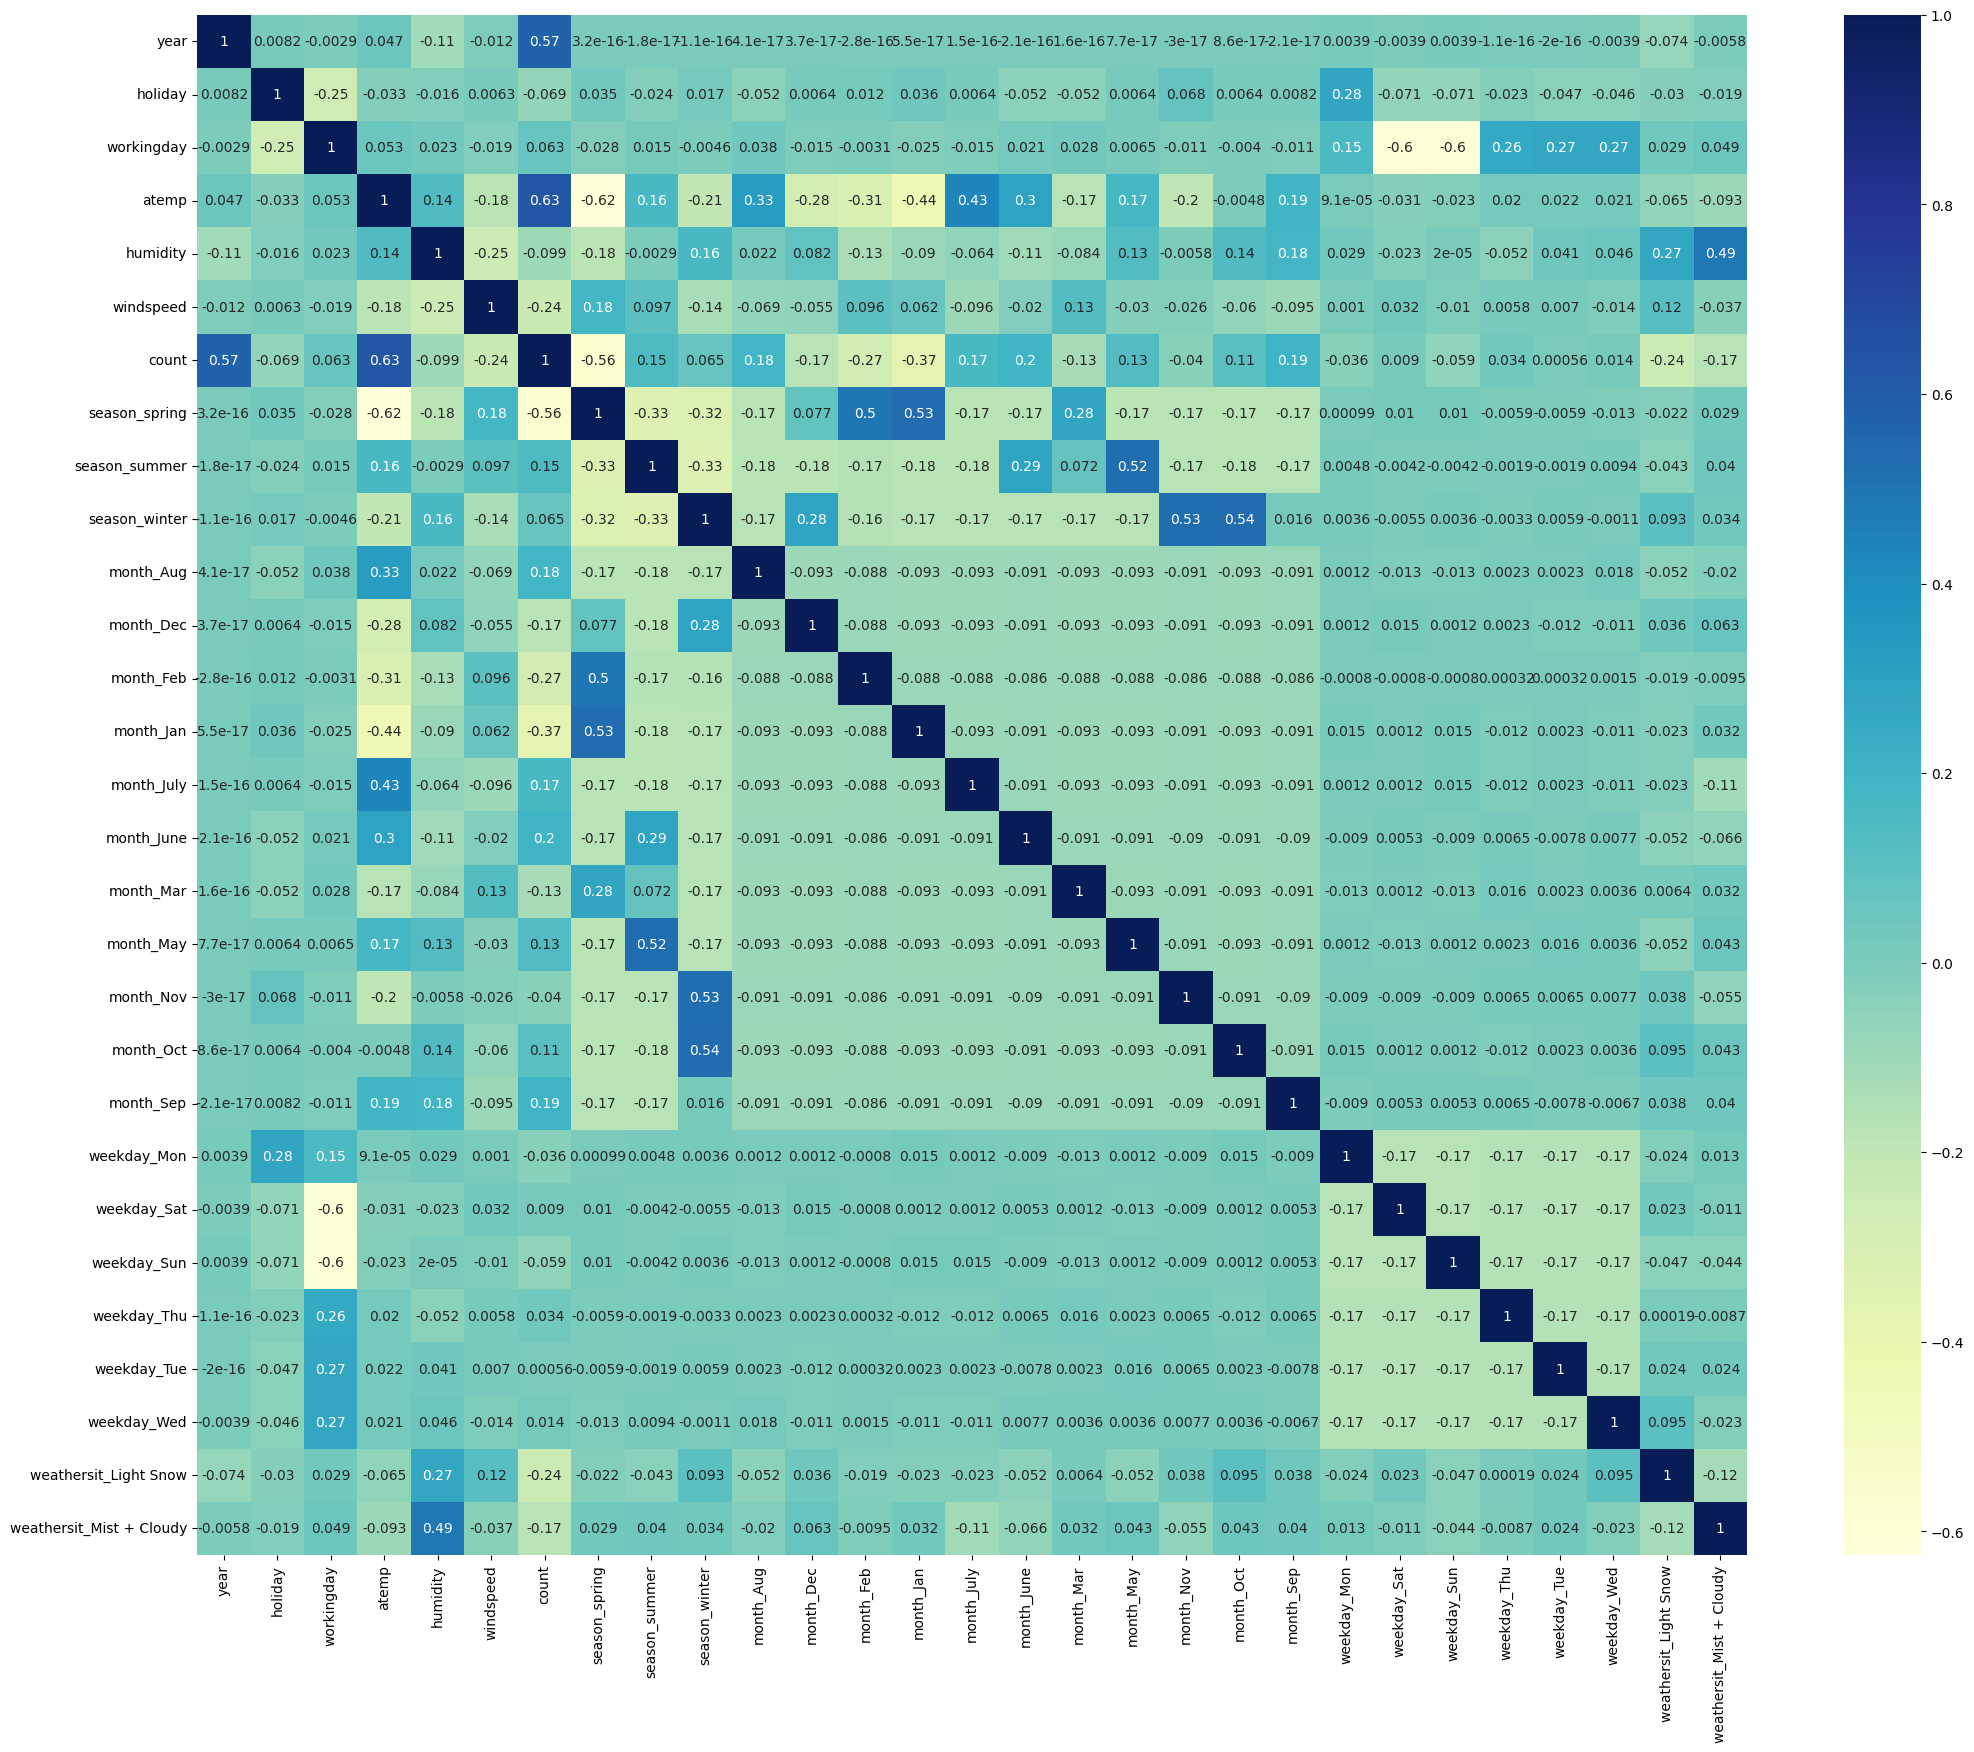

In [16]:
#check the correlation between current variables using heatmap
plt.figure(figsize=(25, 20))
sns.heatmap(bike_df.corr(), cmap='YlGnBu', annot = True)
plt.show()

atemp, year, season_summer, june to oct are highly correlated with count variable.

In [17]:
bike_df.head()

,year,holiday,workingday,atemp,humidity,windspeed,count,season_spring,season_summer,season_winter,...,month_Oct,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow,weathersit_Mist + Cloudy
0,0,0,0,18.18125,80.5833,10.749882,985,True,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0,0,0,17.68695,69.6087,16.652113,801,True,False,False,...,False,False,False,False,True,False,False,False,False,True
2,0,0,1,9.47025,43.7273,16.636703,1349,True,False,False,...,False,False,True,False,False,False,False,False,False,False
3,0,0,1,10.60610,59.0435,10.739832,1562,True,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0,0,1,11.46350,43.6957,12.522300,1600,True,False,False,...,False,False,False,False,False,False,False,True,False,False


In [18]:
#convert bool to int
bool_columns = bike_df.select_dtypes(include=['bool']).columns
bike_df[bool_columns] = bike_df[bool_columns].apply(lambda x: x.astype(int))

## Step 4: Split the data into Training and Testing set

Follwing 70-30 split 

In [19]:
bike_train, bike_test = train_test_split(bike_df, train_size = 0.7, random_state = 100)

In [20]:
print(bike_train.shape)
print(bike_test.shape)

(510, 29)
(220, 29)


- Scaling the data to make sure coefficients obtained are all on the same scale.
    - Follwing min-max scaling  

In [21]:
scaler = MinMaxScaler()

In [22]:
#Create a list of numeric variables
num_vars=['atemp','humidity','windspeed','count']

#Fit on data
bike_train[num_vars] = scaler.fit_transform(bike_train[num_vars])
bike_train.head()

,year,holiday,workingday,atemp,humidity,windspeed,count,season_spring,season_summer,season_winter,...,month_Oct,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow,weathersit_Mist + Cloudy
576,1,0,1,0.766351,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.438975,0.640189,0.255342,0.465255,1,0,0,...,0,0,0,1,0,0,0,0,0,1
728,1,0,0,0.200348,0.498067,0.663106,0.204096,1,0,0,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.391735,0.504508,0.188475,0.482973,0,1,0,...,0,0,0,1,0,0,0,0,0,1
111,0,0,1,0.318819,0.751824,0.380981,0.191095,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [23]:
#Confirm numeric variables(min and max) after scaling
bike_train.describe()

,year,holiday,workingday,atemp,humidity,windspeed,count,season_spring,season_summer,season_winter,...,month_Oct,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow,weathersit_Mist + Cloudy
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.513156,0.650480,0.320883,0.513499,0.243137,0.247059,0.247059,...,0.084314,0.080392,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.029412,0.345098
std,0.500429,0.157763,0.468282,0.212410,0.145846,0.169803,0.224421,0.429398,0.431725,0.431725,...,0.278131,0.272166,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.169124,0.475867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


all max in 1 and min is 0

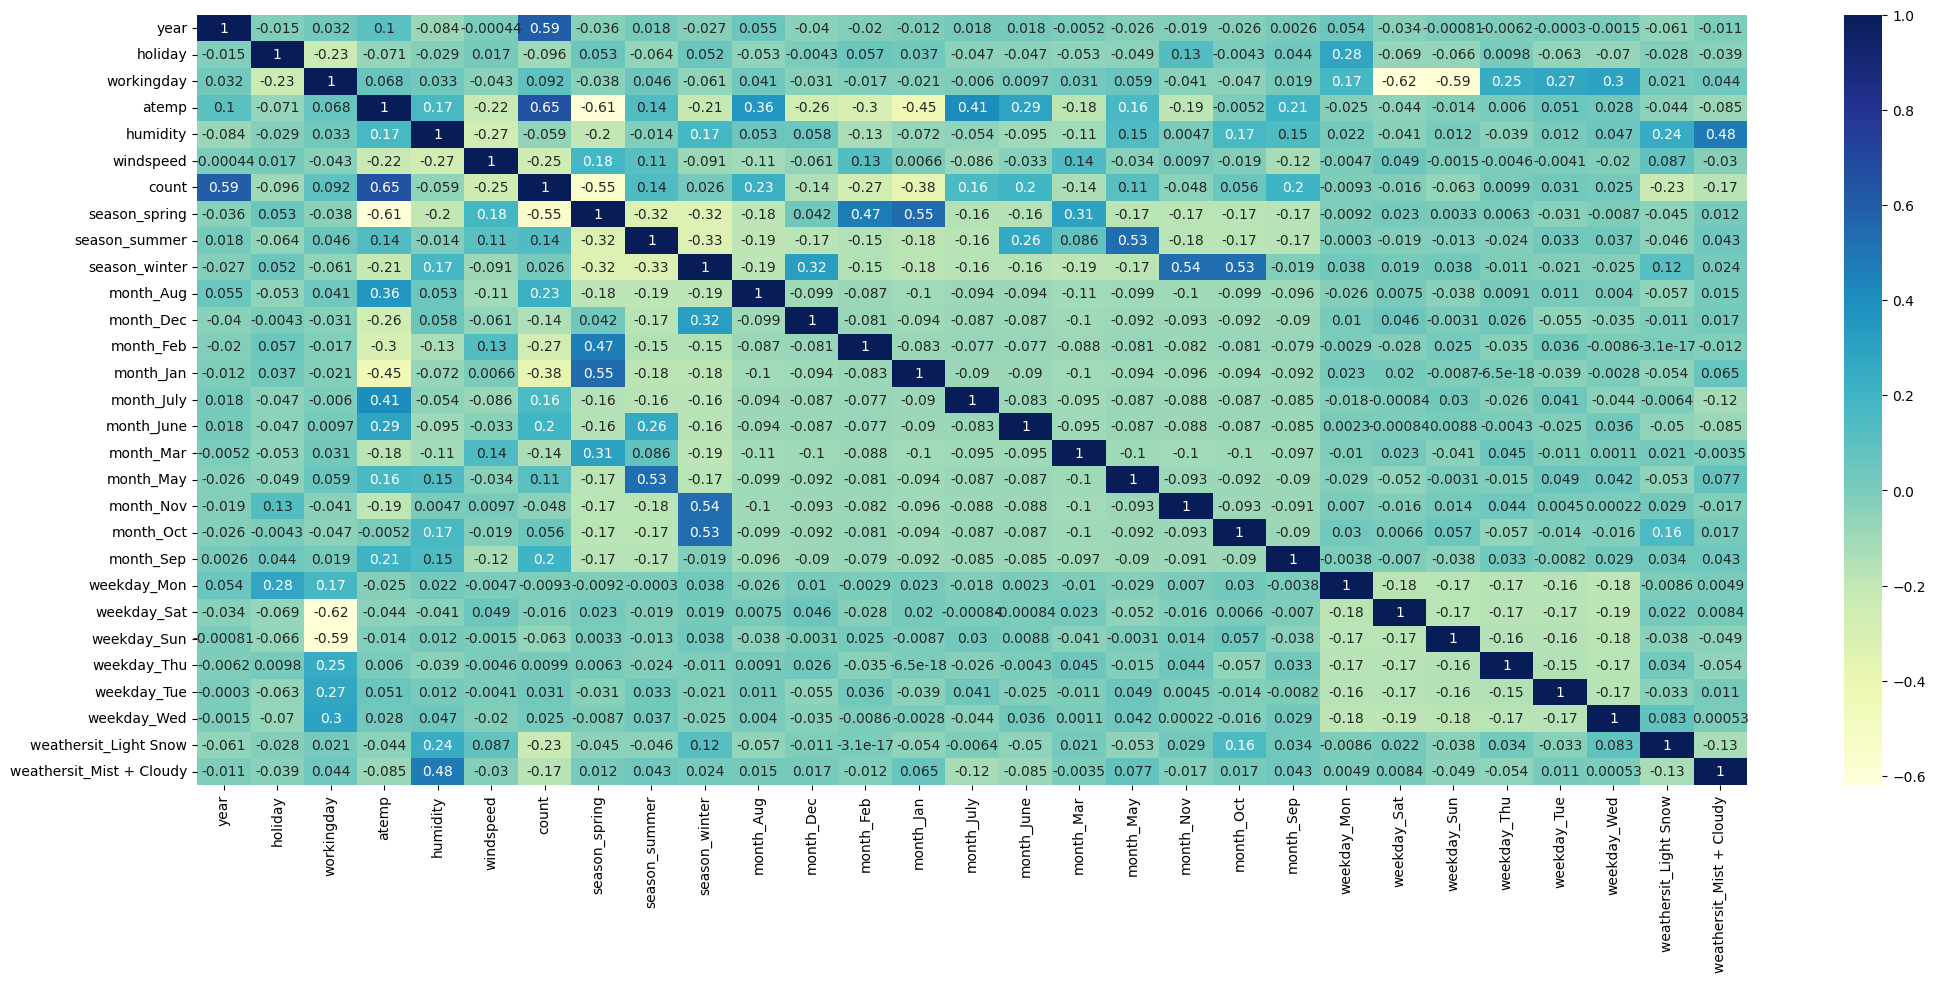

In [24]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (25, 10))
sns.heatmap(bike_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

now variables correlated to count is clearly visible and previous analuyzed variables are still correlated with count variable.

In [25]:
#Divide the data into X and y
y_train = bike_train.pop('count')
X_train = bike_train

## Step 5: Building a linear model

R-Squared is increasing, now lets add all feature variables

In [26]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select = 15)   # running RFE
rfe = rfe.fit(X_train, y_train)

In [27]:
#List variables
print(X_train.columns[rfe.support_]) #rfe true
print(X_train.columns[~rfe.support_]) #rfe false
col = X_train.columns[rfe.support_]

Index(['year', 'holiday', 'workingday', 'atemp', 'humidity', 'windspeed',
       'season_summer', 'season_winter', 'month_Aug', 'month_Jan', 'month_Sep',
       'weekday_Sat', 'weekday_Sun', 'weathersit_Light Snow',
       'weathersit_Mist + Cloudy'],
      dtype='object')
Index(['season_spring', 'month_Dec', 'month_Feb', 'month_July', 'month_June',
       'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'weekday_Mon',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed'],
      dtype='object')


In [28]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [29]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [30]:
#Drop the constant term B0
X_train_rfe = X_train_rfe.drop(['const'], axis=1)

In [31]:
# Running the linear model
lm = sm.OLS(y_train,X_train_rfe).fit()

In [32]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          1.52e-188
Time:                        23:48:36   Log-Likelihood:                 510.80
No. Observations:                 510   AIC:                            -991.6
Df Residuals:                     495   BIC:                            -928.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
year                    

### Checking VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

Follwing 
- high p-value, high VIF - drop
- High-low:
    - High p, low VIF: remove these first
    - low p, high VIF: remove after previous if values still not changed
- low p-value, low VIF 

In [33]:
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,34.11
11,weekday_Sat,8.40
12,weekday_Sun,8.22
1,holiday,2.24
3,atemp,1.91
4,humidity,1.89
14,weathersit_Mist + Cloudy,1.57
7,season_winter,1.56
9,month_Jan,1.55
6,season_summer,1.49


Rebuilding model after dropping workingday

In [34]:
# Dropping holiday since it has very high p-value

X_train_rfe_1 = X_train_rfe.drop(["holiday"], axis = 1)
X_train_lm = sm.add_constant(X_train_rfe_1)
lm = sm.OLS(y_train,X_train_lm).fit()
# Checking statistical summary of the model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          1.52e-188
Time:                        23:48:36   Log-Likelihood:                 510.80
No. Observations:                 510   AIC:                            -991.6
Df Residuals:                     495   BIC:                            -928.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [35]:
vif = pd.DataFrame()
X = X_train_rfe_1
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,humidity,27.24
1,workingday,16.08
2,atemp,12.35
4,windspeed,4.37
10,weekday_Sat,4.36
11,weekday_Sun,4.27
13,weathersit_Mist + Cloudy,2.23
0,year,2.07
6,season_winter,2.04
5,season_summer,1.97


In [36]:
# Dropping weekday_Sun since it has high VIF and high p-value when all variables are significant

X_train_rfe_1 = X_train_rfe_1.drop(["weekday_Sun"], axis = 1)
# Adding constant variable
X_train_lm = sm.add_constant(X_train_rfe_1)
# Running the linear model
lm = sm.OLS(y_train,X_train_lm).fit()
# Checking statistical summary of the model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     202.8
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          6.87e-189
Time:                        23:48:36   Log-Likelihood:                 508.85
No. Observations:                 510   AIC:                            -989.7
Df Residuals:                     496   BIC:                            -930.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [37]:
vif = pd.DataFrame()
X = X_train_rfe_1
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,humidity,19.69
2,atemp,11.71
1,workingday,4.59
4,windspeed,3.77
12,weathersit_Mist + Cloudy,2.15
0,year,2.04
6,season_winter,2.02
5,season_summer,1.97
10,weekday_Sat,1.81
8,month_Jan,1.56


In [38]:
# Dropping humidity since it has high VIF

X_train_rfe_1 = X_train_rfe_1.drop(["humidity"], axis = 1)
# Adding constant variable
X_train_lm = sm.add_constant(X_train_rfe_1)
# Running the linear model
lm = sm.OLS(y_train,X_train_lm).fit()
# Checking statistical summary of the model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     210.7
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          3.96e-186
Time:                        23:48:36   Log-Likelihood:                 499.50
No. Observations:                 510   AIC:                            -973.0
Df Residuals:                     497   BIC:                            -918.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [39]:
vif = pd.DataFrame()
X = X_train_rfe_1
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,atemp,6.22
1,workingday,4.31
3,windspeed,3.56
0,year,2.04
4,season_summer,1.93
9,weekday_Sat,1.76
5,season_winter,1.60
11,weathersit_Mist + Cloudy,1.57
6,month_Aug,1.56
8,month_Sep,1.31


In [40]:
# Dropping workingday since it has high VIF

X_train_rfe_1 = X_train_rfe_1.drop(["workingday"], axis = 1)
# Adding constant variable
X_train_lm = sm.add_constant(X_train_rfe_1)
# Running the linear model
lm = sm.OLS(y_train,X_train_lm).fit()
# Checking statistical summary of the model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     217.8
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          2.65e-182
Time:                        23:48:36   Log-Likelihood:                 487.63
No. Observations:                 510   AIC:                            -951.3
Df Residuals:                     498   BIC:                            -900.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [41]:
vif = pd.DataFrame()
X = X_train_rfe_1
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,atemp,4.97
2,windspeed,3.31
0,year,2.04
3,season_summer,1.91
4,season_winter,1.56
5,month_Aug,1.56
10,weathersit_Mist + Cloudy,1.54
7,month_Sep,1.31
6,month_Jan,1.22
8,weekday_Sat,1.18


In [42]:
# Dropping weekday_Sat since it has high p-value

X_train_rfe_2 = X_train_rfe_1.drop(["windspeed"], axis = 1)
# Adding constant variable
X_train_lm = sm.add_constant(X_train_rfe_2)
# Running the linear model
lm_final = sm.OLS(y_train,X_train_lm).fit()
# Checking statistical summary of the model
print(lm_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     223.1
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          5.37e-177
Time:                        23:48:36   Log-Likelihood:                 472.26
No. Observations:                 510   AIC:                            -922.5
Df Residuals:                     499   BIC:                            -875.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [43]:
vif = pd.DataFrame()
X = X_train_rfe_2
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,atemp,3.98
0,year,2.00
2,season_summer,1.85
4,month_Aug,1.55
3,season_winter,1.52
9,weathersit_Mist + Cloudy,1.52
6,month_Sep,1.30
7,weekday_Sat,1.16
5,month_Jan,1.14
8,weathersit_Light Snow,1.06


In [44]:
# Dropping weekday_Sat since it has high p-value

X_train_rfe_2 = X_train_rfe_2.drop(["weekday_Sat"], axis = 1)
# Adding constant variable
X_train_lm = sm.add_constant(X_train_rfe_2)
# Running the linear model
lm_final = sm.OLS(y_train,X_train_lm).fit()
# Checking statistical summary of the model
print(lm_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     246.9
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          1.14e-177
Time:                        23:48:36   Log-Likelihood:                 470.99
No. Observations:                 510   AIC:                            -922.0
Df Residuals:                     500   BIC:                            -879.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [45]:
vif = pd.DataFrame()
X = X_train_rfe_2
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,atemp,3.91
0,year,2.00
2,season_summer,1.85
4,month_Aug,1.55
8,weathersit_Mist + Cloudy,1.52
3,season_winter,1.51
6,month_Sep,1.30
5,month_Jan,1.13
7,weathersit_Light Snow,1.06


In [46]:
#month_Jan
# Dropping weekday_Sat since it has high p-value

X_train_rfe_2 = X_train_rfe_2.drop(["month_Jan"], axis = 1)
# Adding constant variable
X_train_lm = sm.add_constant(X_train_rfe_2)
# Running the linear model
lm_final = sm.OLS(y_train,X_train_lm).fit()
# Checking statistical summary of the model
print(lm_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     276.1
Date:                Sun, 28 Jul 2024   Prob (F-statistic):          3.36e-178
Time:                        23:48:36   Log-Likelihood:                 469.34
No. Observations:                 510   AIC:                            -920.7
Df Residuals:                     501   BIC:                            -882.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [47]:
vif = pd.DataFrame()
X = X_train_rfe_2
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,atemp,3.90
0,year,1.93
2,season_summer,1.80
4,month_Aug,1.53
3,season_winter,1.47
7,weathersit_Mist + Cloudy,1.45
5,month_Sep,1.28
6,weathersit_Light Snow,1.06


Since all vif values are <5 and R-Squared is 0.827 and adjusted R-Squared is 0.823 so we can consider this as perfect model for prediction. 

## Model validation and test set prediction

In [48]:
y_train_pred = lm_final.predict(X_train_lm)

Text(0.5, 0, 'Errors')

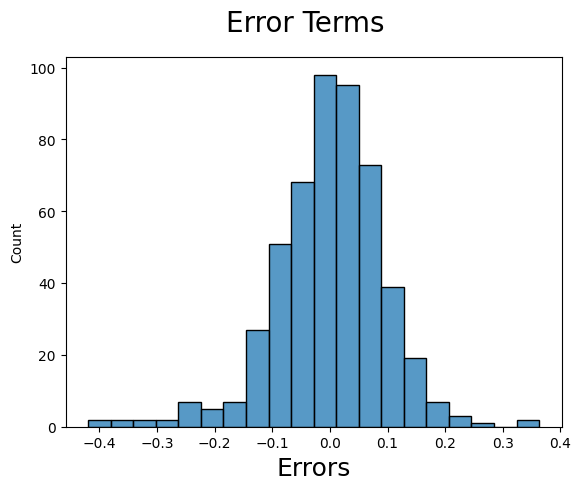

In [49]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.histplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)  

In [50]:
# Rescaling atemp, humidity, windspeed and count in bike_test
num_vars = ['atemp','humidity','windspeed','count']
bike_test[num_vars] = scaler.transform(bike_test[num_vars])
bike_test.head()

,year,holiday,workingday,atemp,humidity,windspeed,count,season_spring,season_summer,season_winter,...,month_Oct,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow,weathersit_Mist + Cloudy
184,0,1,0,0.769660,0.657364,0.084219,0.692706,0,0,0,...,0,0,1,0,0,0,0,0,0,1
535,1,0,1,0.842587,0.610133,0.153728,0.712034,0,1,0,...,0,0,0,0,0,0,0,1,0,0
299,0,0,1,0.496145,0.837699,0.334206,0.303382,0,0,1,...,1,0,0,0,0,1,0,0,0,1
221,0,0,1,0.795343,0.437098,0.339570,0.547400,0,0,0,...,0,0,0,0,0,0,0,1,0,0
152,0,0,1,0.741471,0.314298,0.537414,0.569029,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [51]:
# Dividing into X and y

y_test = bike_test.pop('count')
X_test = bike_test

In [52]:
# Creating X_test_new after droppping variables which are not there in the final model
X_test_new = X_test[X_train_rfe_2.columns]

# Adding a constant variable
X_test_new = sm.add_constant(X_test_new)

# Making predictions using final model
y_test_pred = lm_final.predict(X_test_new)

Text(0, 0.5, 'y_test_pred')

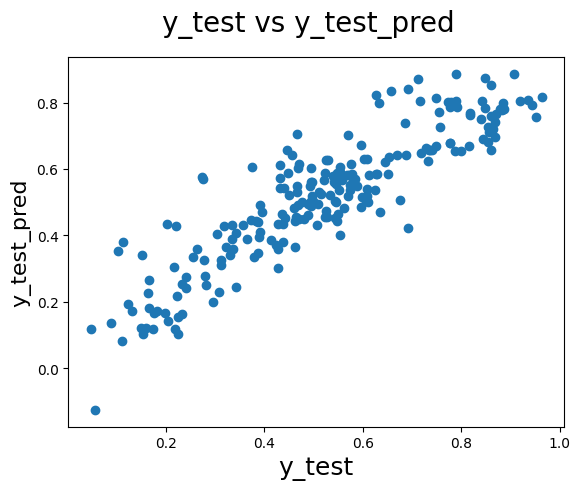

In [53]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize = 20) # Plot heading 
plt.xlabel('y_test', fontsize = 18) # X-label
plt.ylabel('y_test_pred', fontsize = 16)      

In [54]:
# R-squared value for the final model on test set

r2_test = r2_score(y_test, y_test_pred)
print(f"Testing r2 suqared {r2_test}")
r2_train = r2_score(y_train, y_train_pred)
print(f"Training r2 suqared {r2_train}")

Testing r2 suqared 0.7964173504826224
Training r2 suqared 0.815108456746243


In [55]:
# Adjusted R-squared value for the final model on test set

adjusted_r2_test = 1-(1-r2_test)*((bike_test.shape[0]-1)/(bike_test.shape[0]-10-1))
adjusted_r2_train = 1-(1-r2_test)*((bike_train.shape[0]-1)/(bike_train.shape[0]-10-1))

print(f"Testing adjusted r-squared {adjusted_r2_test}")
print(f"Training adjusted r-squared {adjusted_r2_train}")

Testing adjusted r-squared 0.7866765538549967
Training adjusted r-squared 0.7923375378670436


In [56]:
#variables for final model
X_train_rfe_2.columns

Index(['year', 'atemp', 'season_summer', 'season_winter', 'month_Aug',
       'month_Sep', 'weathersit_Light Snow', 'weathersit_Mist + Cloudy'],
      dtype='object')

Text(0.5, 1.0, 'Q-Q Plot of Residuals')

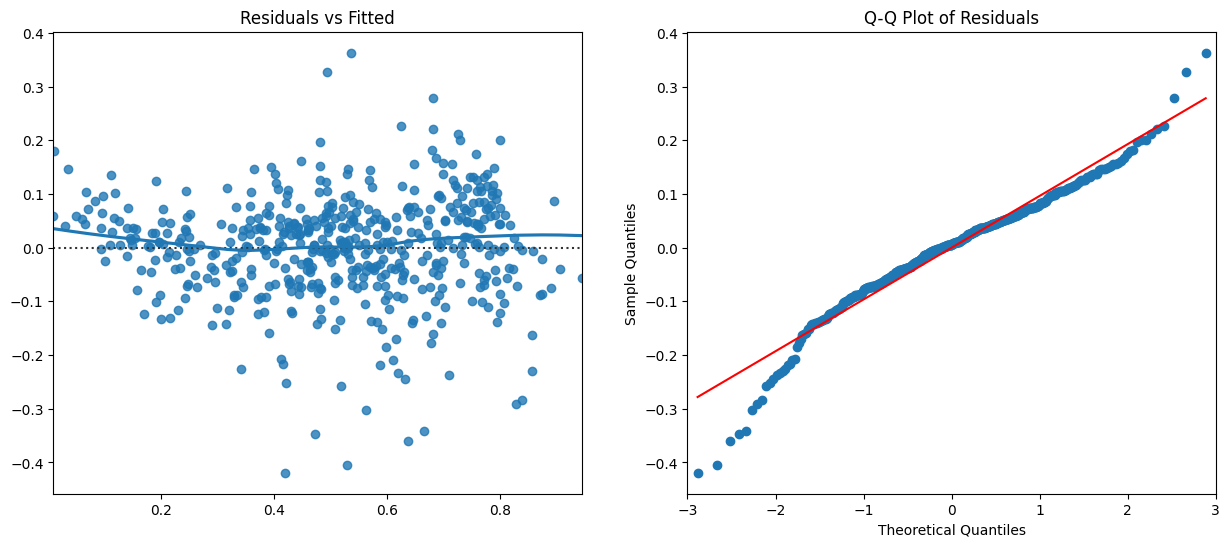

In [57]:
residuals = lm_final.resid

# Residuals plot
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.residplot(x=lm_final.fittedvalues, y=residuals, lowess=True)
plt.title('Residuals vs Fitted')


# Create Q-Q plot
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals')


Based on Q-Q plot we can say that the model is residuals are approximatly normally disctributed. Can observe few outliers as well which indicates that the residuals have heavier tails. This is something to be aware of, although it does not necessarily invalidate this model.

**Some findings based on the analysis of the dataset**
- Temprature has highest coef on the final model 
- Based on 2 years data, rental count growth can be seen easily 
- Can see negative coef. for variables like weathersit_Light Snow, weathersit_Mist + Cloudy. Company need to focus some marketing to improve sales for the variables which has negative/very less coef. with count variable.